In [1]:
import csv
import numpy as np
from numpy import array
from collections import Counter

In [2]:
grid_points = []
time_range = []
with open('temperature.csv', 'r') as f:
    reader = csv.reader(f)
    for i in reader:
        tmp = i[0].split('grid_points:')[0].replace('Data set:    ',
                                                  '').replace('\n', ',')
        exec(f"a={tmp}")
        a = np.array(a[0])
        grid_points.append(a[0,:,0])
        exec(f"a={i[0].split(':')[2].split('time range')[0][4:]}")
        time_range.append(a[0])
grid_points = np.array(grid_points)
time_range = time_range[0]
dr_temp = np.loadtxt('DR_temperature.csv', delimiter=',').T
print("dr_temp shape: ", dr_temp.shape)
climate = []
with open('climate.csv', 'r') as f:
    reader = csv.reader(f)
    for i in reader:
        climate.append(''.join(i))
print("climate length:", len(climate))
print("grid_points shape:", grid_points.shape)
print("time range shape: ", time_range.shape)

dr_temp shape:  (35, 16)
climate length: 35
grid_points shape: (35, 365)
time range shape:  (365,)


In [26]:
data_x = grid_points
data_x_comp = dr_temp
c_type = Counter(climate).keys()
c_type_map = {i:j for j,i in enumerate(c_type)}
c_type_map['Continental'] = 0
c_type_map['Pacific'] = 1
c_type_map['Arctic'] = 1
data_y = np.array([c_type_map[i] for i in climate])
idx = np.where(data_y < 2)

data_x = data_x[idx][19:]
data_x_comp = data_x_comp[idx][19:]
data_y = data_y[idx][19:]

# Classical model

In [168]:
import mindspore.nn as nn
import mindspore as ms
import mindspore.dataset as ds

In [165]:
class ClassNet(nn.Cell):
    def __init__(self, n_feature):
        super(ClassNet, self).__init__()
        self.dense_relu_sequential = nn.SequentialCell(nn.Dense(n_feature, 128),
                                                       nn.ReLU(),
                                                       nn.Dense(128, 128),
                                                       nn.ReLU(),
                                                       nn.Dense(128, 4))
    def construct(self, x):
        return self.dense_relu_sequential(x)

data_t_x = ms.Tensor(data_x, dtype=ms.float32)
data_t_x_comp = ms.Tensor(data_x_comp, dtype=ms.float32)
data_t_y = ms.Tensor(data_y, dtype=ms.int32)

In [203]:
use_pca_data = False
if use_pca_data:
    used_data = data_t_x_comp
else:
    used_data = data_t_x

net = ClassNet(used_data.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(net.trainable_params(), 1e-2)


def forward_fn(data, label):
    logits = net(data)
    loss = loss_fn(logits, label)
    return loss, logits
grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)


def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss


def train(model, dataset, epoch_id):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if epoch_id % 10 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"epoch: {epoch_id:3d} loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

train_ds = ds.NumpySlicesDataset(
        {"image": used_data, "label": data_t_y}, shuffle=True
    ).batch(35)

epochs = 300
for t in range(epochs):
    train(net, train_ds, t)
print("Done!")
print(net)
acc = np.mean(net(used_data).asnumpy().argmax(axis=1) == data_y)
print(f"acc: {acc}")

epoch:   0 loss: 2.437538  [  0/  1]
epoch:  10 loss: 0.476867  [  0/  1]
epoch:  20 loss: 0.414870  [  0/  1]
epoch:  30 loss: 0.493565  [  0/  1]
epoch:  40 loss: 0.338376  [  0/  1]
epoch:  50 loss: 0.248410  [  0/  1]
epoch:  60 loss: 0.566728  [  0/  1]
epoch:  70 loss: 0.179182  [  0/  1]
epoch:  80 loss: 0.729157  [  0/  1]
epoch:  90 loss: 0.148875  [  0/  1]
epoch: 100 loss: 0.131785  [  0/  1]
epoch: 110 loss: 0.246550  [  0/  1]
epoch: 120 loss: 0.126072  [  0/  1]
epoch: 130 loss: 0.103990  [  0/  1]
epoch: 140 loss: 0.094240  [  0/  1]
epoch: 150 loss: 0.086253  [  0/  1]
epoch: 160 loss: 0.079772  [  0/  1]
epoch: 170 loss: 0.074495  [  0/  1]
epoch: 180 loss: 0.069533  [  0/  1]
epoch: 190 loss: 0.064932  [  0/  1]
epoch: 200 loss: 0.060700  [  0/  1]
epoch: 210 loss: 0.057853  [  0/  1]
epoch: 220 loss: 0.054292  [  0/  1]
epoch: 230 loss: 0.051445  [  0/  1]
epoch: 240 loss: 0.048711  [  0/  1]
epoch: 250 loss: 0.046301  [  0/  1]
epoch: 260 loss: 0.043981  [  0/  1]
e

# Quantum model

/home/xuxs/gitee/mindquantum/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: parallel_for failed: cudaErrorNoKernelImageForDevice: no kernel image is available for execution on the device
  from .available_simulator import SUPPORTED_SIMULATOR
[WARNING] ME(8372:140172797064000,MainProcess):2023-10-27-21:07:41.341.113 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.2.72 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


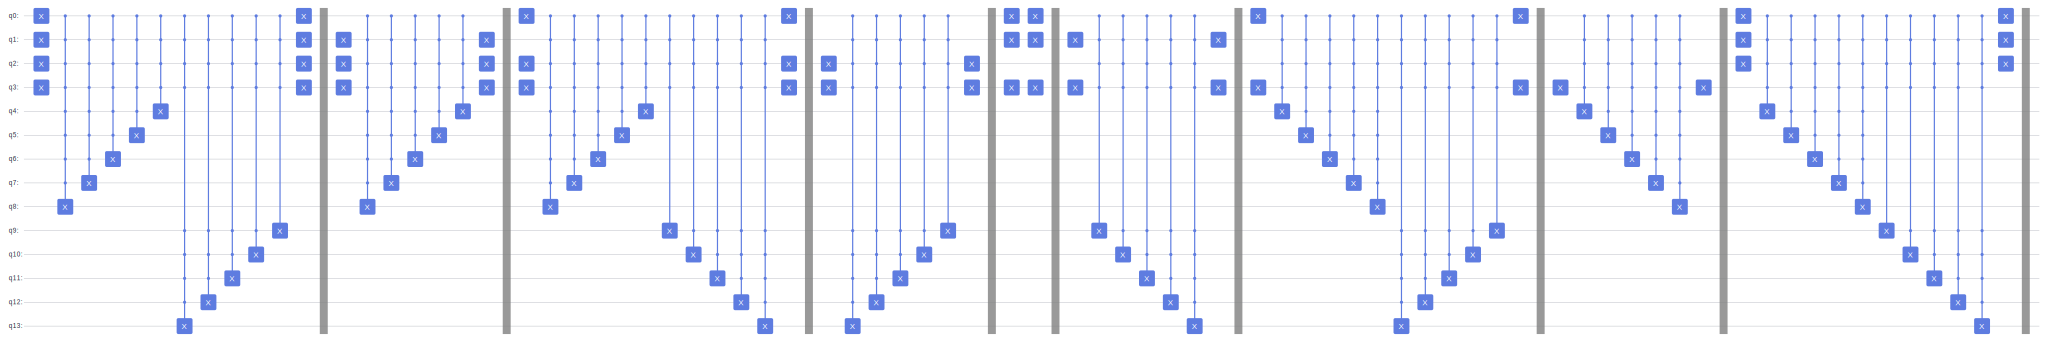

In [7]:
from mindquantum import *


def int_to_ctrl(n, l):
    """
    Examples:
        >>> int_to_ctrl(3, 4).barrier()
        q2: ──X──‖
                 ‖
        q3: ──X──‖
    """
    n = bin(n)[2:].zfill(l)[::-1]
    circ = Circuit()
    for i, j in enumerate(n):
        if j == '0':
            circ += X.on(i)
    return circ


def e1_circ(n_qubits: int) -> Circuit:
    """
    Examples:
        >>> e1_circ(4)
        q0: ──●────●────●────X──
              │    │    │
        q1: ──●────●────X───────
              │    │
        q2: ──●────X────────────
              │
        q3: ──X─────────────────
    """
    circ = Circuit()
    for i in range(n_qubits)[::-1]:
        circ += X.on(i, list(range(i)))
    return circ

def e3_circ(n_qubits: int) -> Circuit:
    """
    Examples:
        >>> e3_circ(4)
        q0: ──X────●────●────●──
                   │    │    │
        q1: ───────X────●────●──
                        │    │
        q2: ────────────X────●──
                             │
        q3: ─────────────────X──
    """
    return e1_circ(n_qubits).hermitian()


def gene_q(n_work):
    n = n_work//2
    e = [e1_circ(n), UN(I, n), e3_circ(n)]
    q = []
    half = list(range(n, n_work))
    for i in e:
        for j in e:
            q.append(i + apply(j, half))

    working = list(range(4, 4+n_work))
    ctrl_reg = list(range(4))
    circ = Circuit()

    for idx, i in enumerate(q):
        flip = int_to_ctrl(idx, 4)
        circ += flip
        circ += controlled(apply(i, working))(ctrl_reg)
        circ += flip
        circ += BarrierGate()
    return Circuit([g for g in circ if not isinstance(g, I.__class__)])

gene_q(10).svg()

In [8]:
def gene_h(n_work):
    half = n_work//2
    h = []
    qid = list(range(4, 4 + half - 1)) + list(range(4 + half, 4 + n_work - 1))
    for i in qid:
        h.append(Hamiltonian(QubitOperator(f"Z{i}")))
    for i in qid:
        for j in qid:
            if i < j:
                h.append(Hamiltonian(QubitOperator(f"Z{i} Z{j}")))
    h.append(Hamiltonian(QubitOperator("")))
    return h
print(',\n'.join(str(i) for i in gene_h(10)))

1 [Z4],
1 [Z5],
1 [Z6],
1 [Z7],
1 [Z9],
1 [Z10],
1 [Z11],
1 [Z12],
1 [Z4 Z5],
1 [Z4 Z6],
1 [Z4 Z7],
1 [Z4 Z9],
1 [Z4 Z10],
1 [Z4 Z11],
1 [Z4 Z12],
1 [Z5 Z6],
1 [Z5 Z7],
1 [Z5 Z9],
1 [Z5 Z10],
1 [Z5 Z11],
1 [Z5 Z12],
1 [Z6 Z7],
1 [Z6 Z9],
1 [Z6 Z10],
1 [Z6 Z11],
1 [Z6 Z12],
1 [Z7 Z9],
1 [Z7 Z10],
1 [Z7 Z11],
1 [Z7 Z12],
1 [Z9 Z10],
1 [Z9 Z11],
1 [Z9 Z12],
1 [Z10 Z11],
1 [Z10 Z12],
1 [Z11 Z12],
1 []


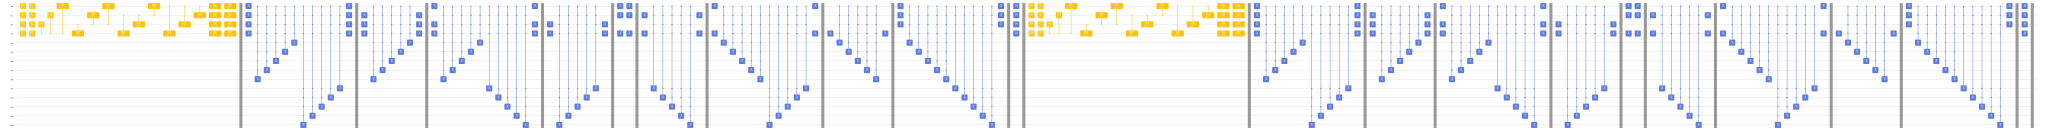

In [9]:
def gene_model(n_work, layer=3):
    circ = Circuit()
    # for l in range(layer):
    #     for i in range(4):
    #         circ += RY(f'p{l}_{i}').on(i)
    #     for i in range(4):
    #         circ += X.on(i, (i + 1) % 4)
    for i in range(layer):
        circ += Ansatz6(4, 1, suffix=f'{i}').circuit
        circ += BarrierGate()
        circ += gene_q(n_work)
        circ += UN(H, 4)
        circ += BarrierGate()
    return circ
gene_model(10, 2).svg()

## not use pca

In [35]:
import mindspore.nn as nn
import mindspore as ms
import mindspore.dataset as ds

use_pca_data = False
if use_pca_data:
    n_work = 4
    used_data = data_x_comp
else:
    n_work = 10
    used_data = data_x

ham = gene_h(n_work)
circ = gene_model(n_work, layer=3)
sim = Simulator('mqvector', circ.n_qubits)
qnet = QRamVecLayer(ham,
                    circ,
                    sim,
                    weight=ms.Tensor(np.random.uniform(-3, 3,
                                                       len(circ.params_name)),
                                     dtype=ms.float32))


In [36]:
test_y
old_feature_size = used_data.shape[1]
new_feature_size = 2**n_work

if old_feature_size != new_feature_size:
    patched_data = np.append(np.zeros((used_data.shape[0], new_feature_size - old_feature_size), dtype=used_data.dtype), used_data, axis=1)
else:
    patched_data = used_data

data_x_full = np.append(patched_data, np.zeros((used_data.shape[0], 2**(4 + n_work) - patched_data.shape[1]), dtype=used_data.dtype), axis=1)
data_x_full = data_x_full / np.sqrt(
    (np.abs(data_x_full)**2).sum(axis=1))[:, None]
data_t_x_full_r = ms.Tensor(np.real(data_x_full), dtype=ms.float32)
data_t_x_full_i = ms.Tensor(np.imag(data_x_full), dtype=ms.float32)
data_t_y = ms.Tensor(data_y, dtype=ms.int32)

In [37]:
train_ds = ds.NumpySlicesDataset(
    {
        "data_r": data_t_x_full_r,
        "data_i": data_t_x_full_i,
        "label": data_t_y
    },
    shuffle=True).batch(35)

In [38]:
import time


class Network(nn.Cell):

    def __init__(self, n_ham, qnet):
        super(Network, self).__init__()
        self.qnet = qnet
        self.dense = nn.Dense(n_ham, 2)

    def construct(self, psi_r, psi_i):
        return self.dense(self.qnet(psi_r, psi_i))


net = Network(len(ham), qnet)
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-2)


def forward_fn(psi_r, psi_i, label):
    logits = net(psi_r, psi_i)
    loss = loss_fn(logits, label)
    return loss, logits


grad_fn = ms.value_and_grad(forward_fn,
                            None,
                            optimizer.parameters,
                            has_aux=True)


def train_step(psi_r, psi_i, label):
    (loss, _), grads = grad_fn(psi_r, psi_i, label)
    optimizer(grads)
    return loss


In [39]:
for epoch in range(100):
    for step, (qr, qi, t) in enumerate(train_ds):
        loss = train_step(qr, qi, t)
        print(f"{time.ctime()}, epoch: {epoch}, step: {step}, loss: {loss}")

Fri Oct 27 21:31:16 2023, epoch: 0, step: 0, loss: 0.71674466
Fri Oct 27 21:31:18 2023, epoch: 1, step: 0, loss: 0.70982945
Fri Oct 27 21:31:21 2023, epoch: 2, step: 0, loss: 0.707661
Fri Oct 27 21:31:24 2023, epoch: 3, step: 0, loss: 0.7052461
Fri Oct 27 21:31:26 2023, epoch: 4, step: 0, loss: 0.70201707
Fri Oct 27 21:31:29 2023, epoch: 5, step: 0, loss: 0.700475
Fri Oct 27 21:31:31 2023, epoch: 6, step: 0, loss: 0.6993113
Fri Oct 27 21:31:34 2023, epoch: 7, step: 0, loss: 0.6988901
Fri Oct 27 21:31:37 2023, epoch: 8, step: 0, loss: 0.6981226
Fri Oct 27 21:31:39 2023, epoch: 9, step: 0, loss: 0.696869
Fri Oct 27 21:31:42 2023, epoch: 10, step: 0, loss: 0.6956795
Fri Oct 27 21:31:44 2023, epoch: 11, step: 0, loss: 0.6945347
Fri Oct 27 21:31:47 2023, epoch: 12, step: 0, loss: 0.6938032
Fri Oct 27 21:31:49 2023, epoch: 13, step: 0, loss: 0.69330835
Fri Oct 27 21:31:52 2023, epoch: 14, step: 0, loss: 0.69277346
Fri Oct 27 21:31:55 2023, epoch: 15, step: 0, loss: 0.692124
Fri Oct 27 21:31:

In [40]:
res = net(data_t_x_full_r, data_t_x_full_i)
res = res.asnumpy()

In [41]:
res

array([[-0.28110725, -0.12330274],
       [-0.20802388, -0.19247061],
       [-0.11309108, -0.29992902],
       [-0.2598331 , -0.13911802],
       [-0.34038943, -0.06299058],
       [-0.3814071 , -0.02531663],
       [-0.36771703, -0.07369343],
       [-0.36394462, -0.08060492],
       [-0.3437305 , -0.04544427],
       [-0.4110869 , -0.0438443 ],
       [-0.17935197, -0.22118133],
       [-0.07855935, -0.34218663],
       [-0.07216124, -0.34446263],
       [ 0.02360532, -0.4312411 ],
       [ 0.01763465, -0.4358377 ],
       [ 0.05096044, -0.45639932]], dtype=float32)

In [42]:
np.mean(np.argmax(res, axis=1) == data_y)

0.5625

## use pca data

In [27]:
import mindspore.nn as nn
import mindspore as ms
import mindspore.dataset as ds

use_pca_data = True
if use_pca_data:
    n_work = 4
    used_data = data_x_comp
else:
    n_work = 10
    used_data = data_x

ham = gene_h(n_work)
circ = gene_model(n_work, layer=3)
sim = Simulator('mqvector', circ.n_qubits)
qnet = QRamVecLayer(ham, circ, sim, weight=ms.Tensor(np.random.uniform(-3, 3, len(circ.params_name)), dtype=ms.float32))

In [28]:
old_feature_size = used_data.shape[1]
new_feature_size = 2**n_work

if old_feature_size != new_feature_size:
    patched_data = np.append(np.zeros(
        (used_data.shape[0], new_feature_size - old_feature_size),
        dtype=used_data.dtype),
                             used_data,
                             axis=1)
else:
    patched_data = used_data

data_x_full = np.append(
    patched_data,
    np.zeros((used_data.shape[0], 2**(4 + n_work) - patched_data.shape[1]),
             dtype=used_data.dtype),
    axis=1)
data_x_full = data_x_full / np.sqrt(
    (np.abs(data_x_full)**2).sum(axis=1))[:, None]
data_t_x_full_r = ms.Tensor(np.real(data_x_full), dtype=ms.float32)
data_t_x_full_i = ms.Tensor(np.imag(data_x_full), dtype=ms.float32)
data_t_y = ms.Tensor(data_y, dtype=ms.int32)

In [29]:
train_ds = ds.NumpySlicesDataset(
    {
        "data_r": data_t_x_full_r,
        "data_i": data_t_x_full_i,
        "label": data_t_y
    },
    shuffle=True).batch(35)

In [30]:
import time


class Network(nn.Cell):

    def __init__(self, n_ham, qnet):
        super(Network, self).__init__()
        self.qnet = qnet
        self.dense = nn.Dense(n_ham, 2)

    def construct(self, psi_r, psi_i):
        return self.dense(self.qnet(psi_r, psi_i))


net = Network(len(ham), qnet)
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-2)


def forward_fn(psi_r, psi_i, label):
    logits = net(psi_r, psi_i)
    loss = loss_fn(logits, label)
    return loss, logits


grad_fn = ms.value_and_grad(forward_fn,
                            None,
                            optimizer.parameters,
                            has_aux=True)


def train_step(psi_r, psi_i, label):
    (loss, _), grads = grad_fn(psi_r, psi_i, label)
    optimizer(grads)
    return loss


In [31]:
for epoch in range(100):
    for step, (qr, qi, t) in enumerate(train_ds):
        loss = train_step(qr, qi, t)
        print(f"{time.ctime()}, epoch: {epoch}, step: {step}, loss: {loss}")

Fri Oct 27 21:29:54 2023, epoch: 0, step: 0, loss: 0.6960043
Fri Oct 27 21:29:54 2023, epoch: 1, step: 0, loss: 0.6940201
Fri Oct 27 21:29:54 2023, epoch: 2, step: 0, loss: 0.6927593
Fri Oct 27 21:29:54 2023, epoch: 3, step: 0, loss: 0.6916765
Fri Oct 27 21:29:54 2023, epoch: 4, step: 0, loss: 0.69060206
Fri Oct 27 21:29:54 2023, epoch: 5, step: 0, loss: 0.6892158
Fri Oct 27 21:29:54 2023, epoch: 6, step: 0, loss: 0.6881435
Fri Oct 27 21:29:54 2023, epoch: 7, step: 0, loss: 0.68713045
Fri Oct 27 21:29:54 2023, epoch: 8, step: 0, loss: 0.68629795
Fri Oct 27 21:29:54 2023, epoch: 9, step: 0, loss: 0.6855836
Fri Oct 27 21:29:54 2023, epoch: 10, step: 0, loss: 0.6849129
Fri Oct 27 21:29:54 2023, epoch: 11, step: 0, loss: 0.68425727
Fri Oct 27 21:29:54 2023, epoch: 12, step: 0, loss: 0.6836607
Fri Oct 27 21:29:54 2023, epoch: 13, step: 0, loss: 0.68310034
Fri Oct 27 21:29:54 2023, epoch: 14, step: 0, loss: 0.68283296
Fri Oct 27 21:29:54 2023, epoch: 15, step: 0, loss: 0.68266654
Fri Oct 27 

In [32]:
res = net(data_t_x_full_r, data_t_x_full_i)
res = res.asnumpy()

In [33]:
res

array([[ 0.10601716, -0.14473334],
       [ 0.10885154, -0.10181805],
       [ 0.07282307,  0.10326563],
       [ 0.1467033 , -0.07156482],
       [ 0.07453123,  0.16649547],
       [ 0.05685203,  0.208752  ],
       [ 0.06069926,  0.15258743],
       [ 0.06190012,  0.1391784 ],
       [ 0.07758647,  0.15138923],
       [ 0.07116678,  0.07821178],
       [ 0.0833469 , -0.03605586],
       [ 0.07962798,  0.03146264],
       [ 0.06571554,  0.13525727],
       [ 0.06131566,  0.19804421],
       [ 0.0647862 ,  0.17539363],
       [ 0.06128343,  0.18943986]], dtype=float32)

In [34]:
np.mean(np.argmax(res, axis=1) == data_y)

0.8125